In [1]:
from transformers import AutoTokenizer
import torch

import sys
sys.path.append('DeepSeek-V3/inference') #Github slightly newer, I made some source code modification for datatype
# sys.path.append('DeepSeek-V3/DeepSeek-V3/inference') #Hugging face

from model import Transformer, MLA, ModelArgs, apply_rotary_emb
import matplotlib.pyplot as plt

from safetensors.torch import load_model, load_file
import os

In [2]:
save_dir='flowchart_graphics_3'

In [3]:
args=ModelArgs(**{"vocab_size": 129280,
                "dim": 7168,
                "inter_dim": 18432,
                "moe_inter_dim": 2048,
                "n_layers": 61,
                "n_dense_layers": 3,
                "n_heads": 128,
                "n_routed_experts": 256,
                "n_shared_experts": 1,
                "n_activated_experts": 8,
                "n_expert_groups": 8,
                "n_limited_groups": 4,
                "route_scale": 2.5,
                "score_func": "sigmoid",
                "q_lora_rank": 1536,
                "kv_lora_rank": 512,
                "qk_nope_head_dim": 128,
                "qk_rope_head_dim": 64,
                "v_head_dim": 128,
                "dtype": "bf16"}) #fp8 seems out due to my hardware? bf16

In [4]:
model=Transformer(args)

In [5]:
# ckpt_path='/home/stephen/deepseek/DeepSeek-V3/DeepSeek-V3'
ckpt_path='/home/stephen/deepseek/clean_hf_pull/DeepSeek-V3/weights_converted'
# ckpt_path='/home/stephen/deepseek/clean_hf_pull/DeepSeek-V3/weights_converted_2' ##Not enough RAM to load this puppy, could try a middle ground
# rank=0
# world_size=1

#
# missing, unexpected=load_model(model, os.path.join(ckpt_path, 'model-00001-of-000163.safetensors'), strict=False)
# load_model(model, os.path.join(ckpt_path, 'model-00009-of-000163.safetensors'), strict=False)
# missing, unexpected=load_model(model, os.path.join(ckpt_path, "model0-mp1.safetensors"), strict=False) #Result of conversion process

state_dict = load_file(os.path.join(ckpt_path, "model0-mp1.safetensors"), device='cpu')
model_state_dict=model.state_dict()

In [6]:
missing, unexpected = model.load_state_dict(state_dict, strict=False)

In [7]:
len(state_dict), len(missing), len(unexpected)

(846, 44960, 411)

In [8]:
model.layers[0].attn.wq_a.weight.detach().abs().sum()

tensor(7.5078e+08, dtype=torch.bfloat16)

In [9]:
model.embed.weight.detach().abs().sum()

tensor(27375474.)

In [10]:
tokenizer = AutoTokenizer.from_pretrained('/home/stephen/deepseek/DeepSeek-V3/DeepSeek-V3')

In [11]:
tokens=tokenizer.encode("The American flag is red, white, and")

In [12]:
logits=model.forward(torch.tensor([tokens]), start_pos=0) #Dope! Ran on CPU somehow - took a couple minutes. 

In [13]:
tokens

[0, 671, 3707, 14364, 344, 4332, 14, 5403, 14, 305]

### Setup for Forward Pass

In [14]:
start_pos=0 #might need to noodle with this to understad caching
seqlen = torch.tensor([tokens]).size(1)
freqs_cis = model.freqs_cis[start_pos:start_pos+seqlen]

mask = None
if seqlen > 1:
    mask = torch.full((seqlen, seqlen), float("-inf"), device='cpu').triu_(1) #CPUing for now

start_pos, seqlen, freqs_cis.shape, mask.shape

(0, 10, torch.Size([10, 32]), torch.Size([10, 10]))

In [15]:
h = model.embed(torch.tensor([tokens]))

In [16]:
h.shape

torch.Size([1, 10, 7168])

In [17]:
h_out=model.layers[0].attn.forward(h, start_pos, freqs_cis, mask) #Run MLA forward pass from outside

In [18]:
h_out.shape

torch.Size([1, 10, 7168])

In [19]:
h_out_reference=h_out #Use for some rough unit testing that my pipeline is working

In [20]:
h_out_reference #Hmm thos numbers seem big! Maybe it's ok?

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [1171456.,   91648.,  468992.,  ...,  729088.,  667648., -152576.],
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

## Now Forward Pass

In [21]:
x=h
mla=model.layers[0].attn

In [22]:
mla.wo.weight.shape

torch.Size([7168, 16384])

In [23]:
128**2

16384

In [24]:
bsz, seqlen, _ = x.size()
end_pos = start_pos + seqlen
if mla.q_lora_rank == 0:
    q = self.wq(x)
else:
    q = mla.wq_b(mla.q_norm(mla.wq_a(x)))
    print('hay')

hay


In [25]:
h1=mla.wq_a(x)
h2=mla.q_norm(mla.wq_a(x))
q=mla.wq_b(mla.q_norm(mla.wq_a(x))) #Probably not going to worry about query compresssion

In [26]:
q.shape #So there's some potentially interesting juxtoposition here with kv stuff -> this just gets chopped up. maa

torch.Size([1, 10, 24576])

In [27]:
q = q.view(bsz, seqlen, mla.n_local_heads, mla.qk_head_dim) #Ok splitting out the queries across all the heads

In [28]:
q.shape

torch.Size([1, 10, 128, 192])

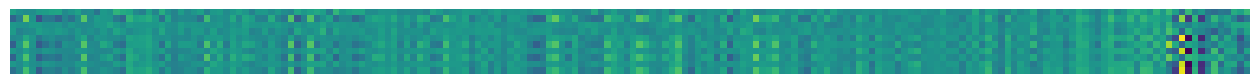

In [29]:
head_id=0
q_to_viz=q[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [30]:
q_nope, q_pe = torch.split(q, [mla.qk_nope_head_dim, mla.qk_rope_head_dim], dim=-1)

In [31]:
q_nope.shape, q_pe.shape #Cool yeah taking the last 64 columns for positional embedding -> dope. I wonder why 64 cols for positional embedding?

(torch.Size([1, 10, 128, 128]), torch.Size([1, 10, 128, 64]))

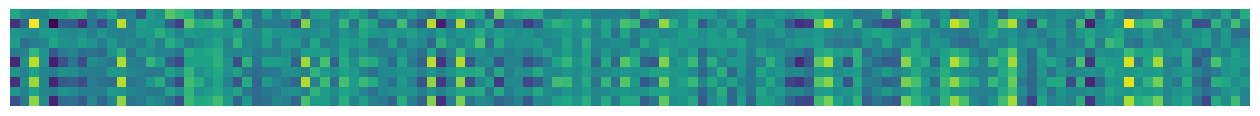

In [32]:
q_to_viz=q_nope[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_nope.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

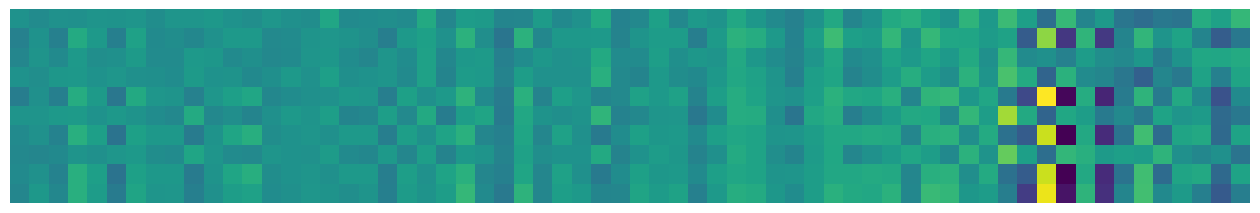

In [33]:
q_to_viz=q_pe[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_pe.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [34]:
q_pe = apply_rotary_emb(q_pe, freqs_cis)

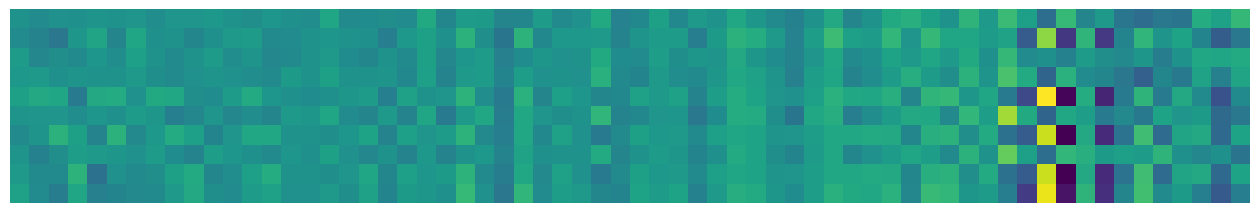

In [35]:
q_to_viz=q_pe[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(q_to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_pe_after_embedding.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [36]:
mla.wkv_a.weight.shape

torch.Size([576, 7168])

In [37]:
kv = mla.wkv_a(x)

In [38]:
kv.shape

torch.Size([1, 10, 576])

So, this is wild b/c it's for all the heads, and I'm pretty sure it doesn't just get like chopped back apart, ya know?

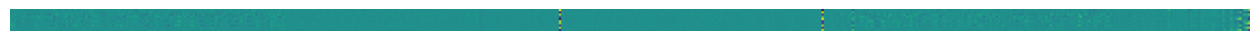

In [39]:
to_viz=kv[0,:,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

Intersting skinteresting

In [40]:
kv, k_pe = torch.split(kv, [mla.kv_lora_rank, mla.qk_rope_head_dim], dim=-1)
k_pe = apply_rotary_emb(k_pe.unsqueeze(2), freqs_cis)

In [41]:
kv.shape, k_pe.shape

(torch.Size([1, 10, 512]), torch.Size([1, 10, 1, 64]))

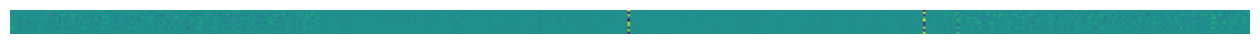

In [42]:
to_viz=kv[0,:,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kv2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

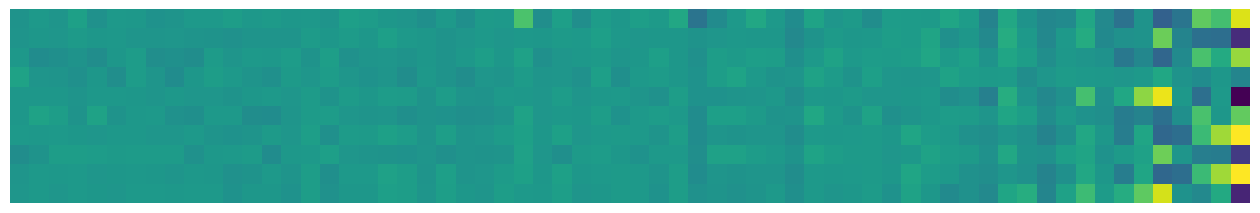

In [43]:
to_viz=k_pe[0,:,0,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/kpe.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

- Man visualizing this is helpful -> chopping off the end and adding positional embeddings
- It's kinda wild that positional embedding work -> they seem so manual
- ROPE could be a fun video - probably to narrow, but we'll see!

In [44]:
# freqs_cis.shape

In [45]:
# to_viz=freqs_cis.detach().cpu().numpy().real
# fig=plt.figure(0,(16,9))
# plt.imshow(to_viz)
# plt.axis('off')
# plt.savefig(save_dir+'/freqs_cis_real.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [46]:
# to_viz=freqs_cis.detach().cpu().numpy().imag
# fig=plt.figure(0,(16,9))
# plt.imshow(to_viz)
# plt.axis('off')
# plt.savefig(save_dir+'/freqs_cis_imag.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [47]:
wkv_b = mla.wkv_b.weight if mla.wkv_b.scale is None else weight_dequant(mla.wkv_b.weight, mla.wkv_b.scale, block_size) 

In [48]:
# wkv_b #Ah ok pulling out the weight from the linear layer -> interesting. 
# This must be part of decoding??

In [49]:
wkv_b.shape #Woah that's a big matrix

torch.Size([32768, 512])

In [50]:
wkv_b = wkv_b.view(mla.n_local_heads, -1, mla.kv_lora_rank)

In [51]:
wkv_b.shape

torch.Size([128, 256, 512])

- ok so the 512 is the kv (without embeddings?) and the 256 will match the query space? (thought that was 192 though?)
- Let's see how it shakes out I guess

In [52]:
q_nope.shape, wkv_b[:, :mla.qk_nope_head_dim].shape

(torch.Size([1, 10, 128, 128]), torch.Size([128, 128, 512]))

In [53]:
wkv_b_slice_copy=torch.clone(wkv_b[:, :mla.qk_nope_head_dim].detach())
wkv_b_slice_copy.shape

torch.Size([128, 128, 512])

In [54]:
tmp=[]
for head_num in range(128):
    tmp.append(q_nope.detach()[0, :, head_num, :] @ wkv_b_slice_copy[head_num])

In [55]:
tmp[0].shape

torch.Size([10, 512])

In [56]:
tmp=torch.stack(tmp, dim=1).unsqueeze(0)

In [57]:
tmp.shape

torch.Size([1, 10, 128, 512])

In [58]:
#Hmm re-using a variable name here before the operation q_nope is torch.Size([1, 10, 128, 128])
q_nope = torch.einsum("bshd,hdc->bshc", q_nope, wkv_b[:, :mla.qk_nope_head_dim]) 
q_nope.shape

torch.Size([1, 10, 128, 512])

In [59]:
torch.testing.assert_close(q_nope, tmp)

In [60]:
mla.qk_nope_head_dim

128

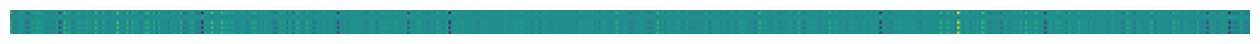

In [61]:
to_viz=q_nope[0,:,0,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/q_nope_2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [62]:
to_viz.shape

(10, 512)

- So we're using part of `wkv_b` weight matrix to like "expand" the queries? Is this a side effect of query compression? Or something else.
- Confused.
- ah this kind make sesnse I think? Breaking apart wkvs weights?
- Eh kinda confused again, is this like an extra step before we can compute the scores I guess?
- Ok I'm not understanding what's happening here on a few levels
- Einstein sum is still a little confusing - i can sort that out thou
- I guess what I'm actualy confused about is why we're muluplying the queries by thie wkv_b matrix? Shouldn't we multiply by the keys to get the scores? How is this more efficient lol?
- Ok, let me keep moving and come back to this -> not following yet. 

In [63]:
mla.kv_cache.shape

torch.Size([8, 16384, 512])

In [64]:
mla.pe_cache.shape

torch.Size([8, 16384, 64])

In [65]:
bsz, start_pos, end_pos

(1, 0, 10)

Hmm where is the 8 coming from? Ah it's `max_batch_size`. 

In [66]:
kv.shape

torch.Size([1, 10, 512])

In [67]:
mla.kv_norm(kv).shape

torch.Size([1, 10, 512])

In [68]:
k_pe.shape

torch.Size([1, 10, 1, 64])

In [69]:
k_pe.squeeze(2).shape

torch.Size([1, 10, 64])

In [70]:
mla.kv_cache[:bsz, start_pos:end_pos] = mla.kv_norm(kv)
mla.pe_cache[:bsz, start_pos:end_pos] = k_pe.squeeze(2)

Ok got it so we're filling up this cache with kv and k_pe. Makes sense, there are some nice ways to visalize. 

In [71]:
q_nope.shape

torch.Size([1, 10, 128, 512])

In [72]:
mla.kv_cache[:bsz, :end_pos].shape

torch.Size([1, 10, 512])

In [73]:
tmp=torch.einsum("bshc,btc->bsht", q_nope, mla.kv_cache[:bsz, :end_pos].to(torch.bfloat16))

In [74]:
tmp.shape

torch.Size([1, 10, 128, 10])

- Ok so this is pretty familiar right? For each head we transpose the queries and take a dot product of a 10x512 by a 512 by 10. What's special here is that we're using the same kv_cache for all the heads.
- What I'm not getting here at all though is how this is any different than Multi Query Attention, which performs worse? How the hell does this perform better? Yeah I dont' get how this is not MQA. 

In [75]:
tmp2=[]
for head_num in range(128):
    tmp2.append(q_nope[0, :, head_num, :].detach() @ mla.kv_cache[:bsz, :end_pos].detach().to(torch.bfloat16)[0].T)

In [76]:
tmp2[0].shape

torch.Size([10, 10])

In [77]:
torch.stack(tmp2, dim=1).unsqueeze(0).shape

torch.Size([1, 10, 128, 10])

In [78]:
torch.testing.assert_close(tmp, torch.stack(tmp2, dim=1).unsqueeze(0)) #Nice

- Man so I feel like a lot of stuff happens to the queries! I thought that that path was going to be more straightforward.
- That's my biggest question here, what the hell is the query path? That and how is this at all different than MQA?

In [79]:
scores = (torch.einsum("bshc,btc->bsht", q_nope, mla.kv_cache[:bsz, :end_pos].to(torch.bfloat16)) +
          torch.einsum("bshr,btr->bsht", q_pe, mla.pe_cache[:bsz, :end_pos].to(torch.bfloat16))) * mla.softmax_scale

Ok, ignoring the positional embedding stuff for now -> i dont' think it's that big of a deal. 

In [80]:
scores.shape

torch.Size([1, 10, 128, 10])

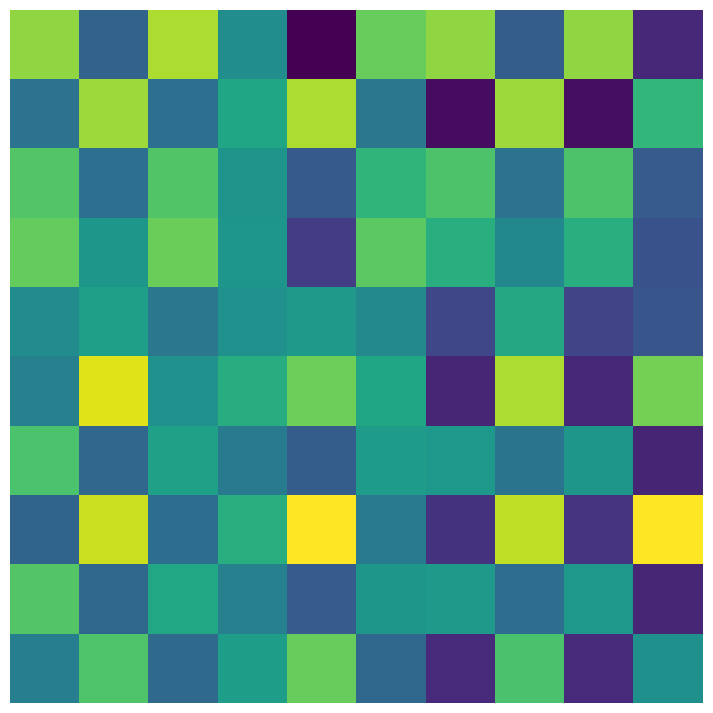

In [81]:
to_viz=scores[0,:,0,:].detach().cpu().float().numpy()
fig=plt.figure(0,(9,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/scores_single_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [82]:
# to_viz=scores[0].detach().cpu().float().numpy()
# fig=plt.figure(0,(16,16))
# for i in range(128):
#     ax=fig.add_subplot(12, 12, i+1)
#     ax.imshow(to_viz[:,i,:])
#     plt.axis('off')
# plt.savefig(save_dir+'/scores_1.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

In [83]:
if mask is not None:
    scores += mask.unsqueeze(1)

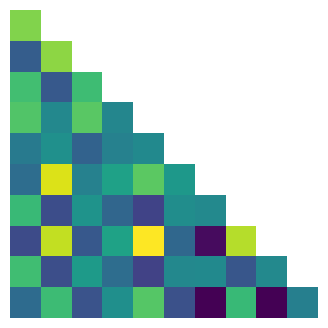

In [84]:
to_viz=torch.clone(scores[0,:,0,:]).detach().cpu().float().numpy()
fig=plt.figure(0,(4,4))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/scores_single_2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

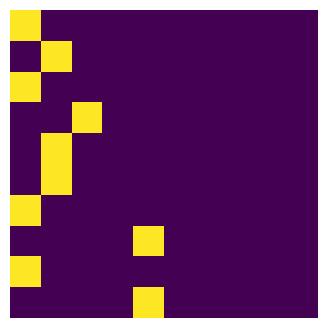

In [85]:
to_viz=torch.clone(scores[0,:,0,:]).detach().cpu()
to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
to_viz=to_viz.float().numpy()

fig=plt.figure(0,(4,4))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/scores_single_3.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [86]:
torch.clone(scores[0,:,0,:].detach().cpu().float())/1e7

tensor([[ 1.5466,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [-0.4686,  1.6253,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 1.1010, -0.5308,  1.0748,    -inf,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [ 1.2255,  0.1974,  1.2780,  0.1761,    -inf,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [-0.0195,  0.3441, -0.3916,  0.0913,  0.2261,    -inf,    -inf,    -inf,
            -inf,    -inf],
        [-0.2212,  2.0709,  0.0938,  0.6062,  1.2976,  0.4620,    -inf,    -inf,
            -inf,    -inf],
        [ 1.0289, -0.6947,  0.3899, -0.3260, -0.8389,  0.2884,  0.2195,    -inf,
            -inf,    -inf],
        [-0.7242,  1.9268, -0.5439,  0.6226,  2.2807, -0.3097, -1.5008,  1.8481,
            -inf,    -inf],
        [ 1.0879, -0.6750,  0.5046, -0.2245, -0.8520,  0.1974,  0.2359, -0.5702,
          0.2195,    -inf],
        [-0.2572,  

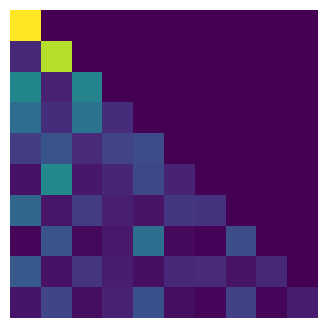

In [87]:
to_viz=torch.clone(scores[0,:,0,:]).detach().cpu().float()/1e7
to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
to_viz=to_viz.float().numpy()

fig=plt.figure(0,(4,4))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/scores_single_4.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

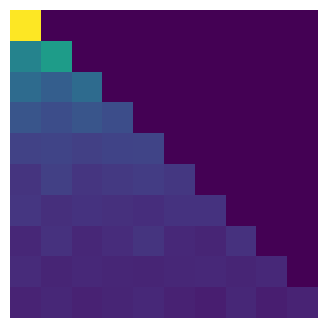

In [88]:
to_viz=torch.clone(scores[0,:,0,:]).detach().cpu().float()/1e8
to_viz=to_viz.softmax(dim=-1, dtype=torch.float32).type_as(x)
to_viz=to_viz.float().numpy()

fig=plt.figure(0,(9,4))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/scores_single_5.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

In [89]:
scores = scores.softmax(dim=-1, dtype=torch.float32).type_as(x)

In [90]:
# to_viz=scores[0].detach().cpu().float().numpy()
# fig=plt.figure(0,(16,16))
# for i in range(128):
#     ax=fig.add_subplot(12, 12, i+1)
#     ax.imshow(to_viz[:,i,:])
#     plt.axis('off')
# plt.savefig(save_dir+'/scores_3.png', dpi=150, transparent=True, bbox_inches='tight')
# plt.show()

- Lol what the fuck is this? Why are we using the kv cache again?
- Oh right becuase it's queries and values?!
- Man that's interesting -> how the hell does that work?

In [91]:
# scores.shape

In [92]:
mla.kv_cache[:bsz, :end_pos].shape #This is the same slice we used before -> mla.kv_cache[:bsz, :end_pos]

torch.Size([1, 10, 512])

In [93]:
scores.shape

torch.Size([1, 10, 128, 10])

In [94]:
x_tmp=[]
for head_num in range(128):
    x_tmp.append(scores[0, :, head_num, :].detach() @ mla.kv_cache[:bsz, :end_pos][0].detach())
x_tmp=torch.stack(x_tmp, dim=1).unsqueeze(0)

In [95]:
x_tmp.shape

torch.Size([1, 10, 128, 512])

In [96]:
x = torch.einsum("bsht,btc->bshc", scores, mla.kv_cache[:bsz, :end_pos]) # On that's intresting - just the cache and attention pattern here.

In [97]:
x.shape

torch.Size([1, 10, 128, 512])

In [98]:
torch.testing.assert_close(x, x_tmp)

- Ok yeah this makes sense, just crazy to me that we're able to use the same kv cache!
- Woah that pattern is kinda interesting - some very strong lines

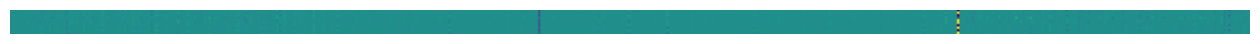

In [99]:
head_id=0
to_viz=x[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/x_1.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

- Woah the other half of the wkv_b matrix? What the hell is happening? This cannot be more computationally efficient right?
- I'm confused.
- Last time was `wkv_b[:, :mla.qk_nope_head_dim]`
- Does it matter that it's 2 halves of the samt matrix?

In [100]:
x.shape

torch.Size([1, 10, 128, 512])

In [101]:
wkv_b[:, -mla.v_head_dim:].shape

torch.Size([128, 128, 512])

In [102]:
x_tmp_2=torch.clone(x.detach())
x_tmp_3=[]
for head_num in range(128):
    x_tmp_3.append(x_tmp_2[0, :, head_num, :].to(torch.bfloat16) @ wkv_b[:, -mla.v_head_dim:][head_num].T)
x_tmp_3=torch.stack(x_tmp_3,dim=1).unsqueeze(0)

In [103]:
x_tmp_3.shape

torch.Size([1, 10, 128, 128])

In [104]:
x = torch.einsum("bshc,hdc->bshd", x.to(torch.bfloat16), wkv_b[:, -mla.v_head_dim:]) #Not sure what this one is doing exactly...

In [105]:
x.shape

torch.Size([1, 10, 128, 128])

In [106]:
torch.testing.assert_close(x, x_tmp_3)

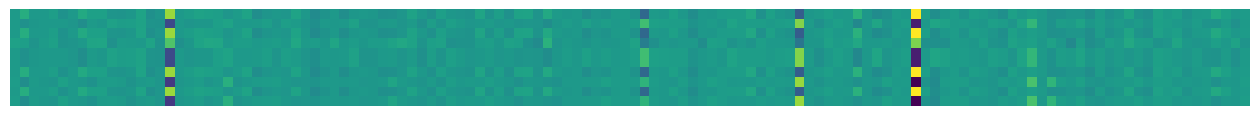

In [107]:
head_id=0
to_viz=x[0,:,head_id,:].detach().cpu().float().numpy()
fig=plt.figure(0,(16,9))
plt.imshow(to_viz)
plt.axis('off')
plt.savefig(save_dir+'/x_2.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

again kinda interesring pattern

In [117]:
mla.wo.weight.shape

torch.Size([7168, 16384])

In [120]:
x.flatten(2).shape

torch.Size([1, 10, 7168])

In [108]:
x = mla.wo(x.flatten(2))

In [119]:
x.shape

torch.Size([1, 10, 7168])

Ok getting warmer but still confused - feels like more computation than naive!

In [110]:
torch.testing.assert_close(x, h_out_reference) #dopety ropety. 

In [111]:
x.shape, h_out_reference.shape

(torch.Size([1, 10, 7168]), torch.Size([1, 10, 7168]))

In [112]:
x

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [1171456.,   91648.,  468992.,  ...,  729088.,  667648., -152576.],
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [113]:
h_out_reference

tensor([[[ 880640., -466944.,  765952.,  ..., -573440., -119296., -456704.],
         [1843200.,  319488.,  774144.,  ...,   88576., -663552., -417792.],
         [1155072.,   36864.,  234496.,  ...,  737280., -892928., -108544.],
         ...,
         [1171456.,   91648.,  468992.,  ...,  729088.,  667648., -152576.],
         [ 142336., -978944., -235520.,  ..., 1376256.,   40192.,  847872.],
         [ 614400.,  374784.,  548864.,  ..., 2097152., -370688.,  454656.]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)